In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def pps(k, k_pivot=0.05, logA = 3.04, n_s = 0.965):
    A = np.exp(logA) / 1e10
    return A * (k / k_pivot)**(n_s - 1)

def pps_run(k, k_pivot=0.05, logA = 3.04, n_s = 0.965, alpha_s = -0.0045):
    A = np.exp(logA) / 1e10
    return A * (k / k_pivot)**(n_s - 1 + 0.5 * alpha_s * np.log(k / k_pivot))

def PPS_rescale(parm, k_pivot_old, k_pivot_new):
    log_A_old = parm[0] # 10 + log10_A_s
    n_s = parm[1]
    log_A_new = log_A_old + (n_s - 1) * np.log(k_pivot_new / k_pivot_old)
    return np.array([log_A_new, n_s])

def PPS_run_rescale(parm, k_pivot_old, k_pivot_new):
    log_A_old = parm[0]
    n_s_old = parm[1]
    alpha_s = parm[2]
    k_ratio = np.log(k_pivot_new / k_pivot_old)
    n_s_new = n_s_old + alpha_s * k_ratio
    log_A_new = log_A_old + (n_s_old - 1) * k_ratio + alpha_s * 0.5 * k_ratio**2

    return np.array([log_A_new, n_s_new, alpha_s])


<Figure size 1000x600 with 0 Axes>

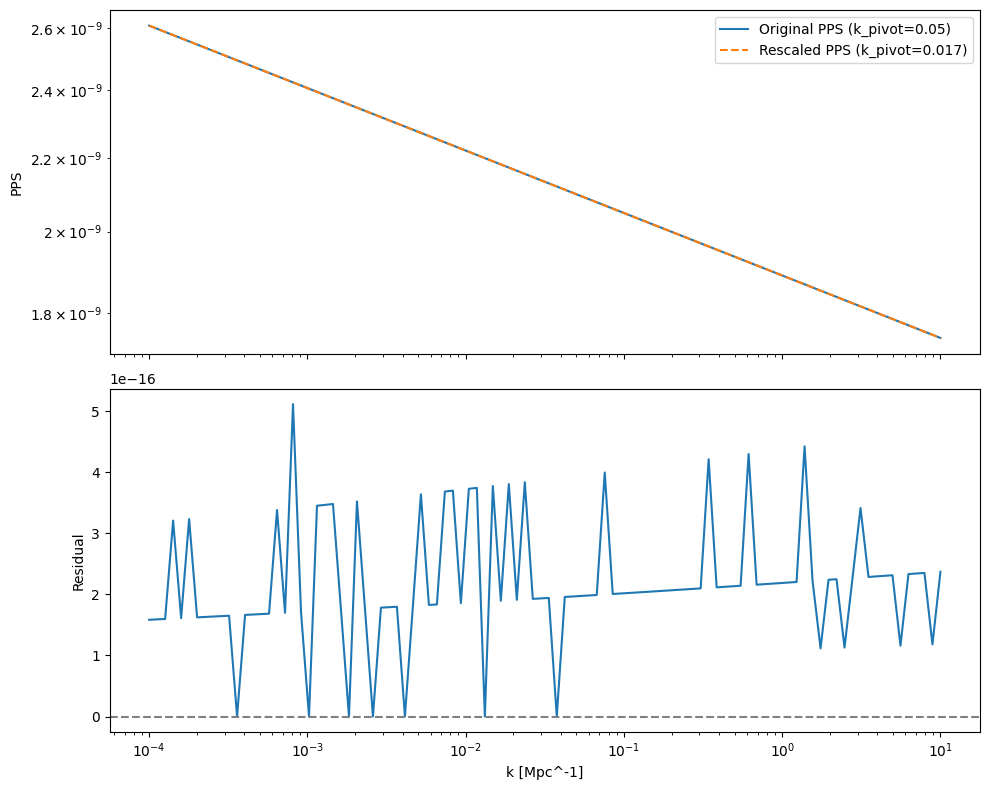

In [88]:
karr = np.logspace(-4, 1, 100)
pps_parm = np.array([3.044, 0.965])

pk_old = pps(karr, k_pivot=0.05, logA=pps_parm[0], n_s=pps_parm[1])
pps_new_parm = PPS_rescale(pps_parm, k_pivot_old=0.05, k_pivot_new = 0.017)
pk_new = pps(karr, k_pivot=0.017, logA=pps_new_parm[0], n_s=pps_new_parm[1])
pk_new = pps(karr, k_pivot=0.017, logA=pps_new_parm[0], n_s=pps_new_parm[1])
residual = (pk_new - pk_old) / pk_old
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax[0].loglog(karr, pk_old, label='Original PPS (k_pivot=0.05)')
ax[0].loglog(karr, pk_new, linestyle='--', label='Rescaled PPS (k_pivot=0.017)')
ax[0].set_ylabel('PPS')
ax[0].legend()
ax[1].semilogx(karr, residual)
ax[1].set_xlabel('k [Mpc^-1]')
ax[1].set_ylabel('Residual')
ax[1].axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show() 


<Figure size 1000x600 with 0 Axes>

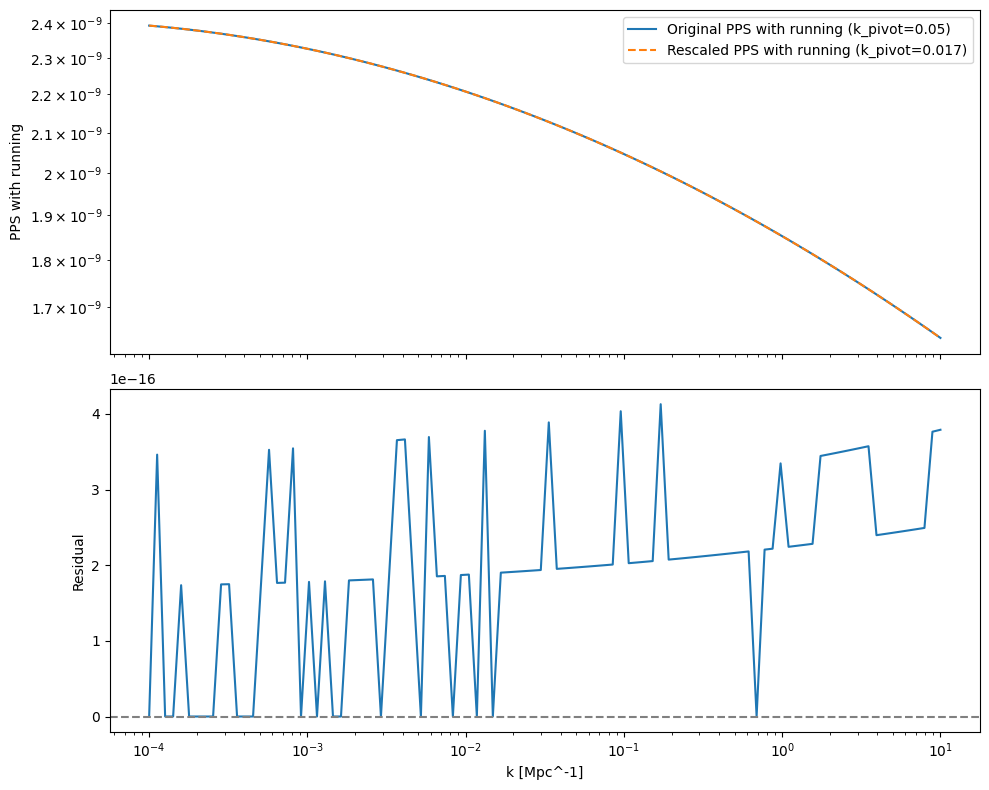

In [89]:
karr = np.logspace(-4, 1, 100)
pps_run_parm = np.array([3.044, 0.965, -0.0045])
pk_run_old = pps_run(karr, k_pivot=0.05, logA=pps_run_parm[0], n_s=pps_run_parm[1], alpha_s=pps_run_parm[2])
pps_run_new_parm = PPS_run_rescale(pps_run_parm, k_pivot_old=0.05, k_pivot_new = 0.017)
pk_run_new = pps_run(karr, k_pivot=0.017, logA=pps_run_new_parm[0], n_s=pps_run_new_parm[1], alpha_s=pps_run_new_parm[2])
residual_run = (pk_run_new - pk_run_old) / pk_run_old
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax[0].loglog(karr, pk_run_old, label='Original PPS with running (k_pivot=0.05)')
ax[0].loglog(karr, pk_run_new, linestyle='--', label='Rescaled PPS with running (k_pivot=0.017)')
ax[0].set_ylabel('PPS with running')
ax[0].legend()
ax[1].semilogx(karr, residual_run)
ax[1].set_xlabel('k [Mpc^-1]')
ax[1].set_ylabel('Residual')
ax[1].axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

In [3]:
chain_paramnames = open('./plikHM_TTTEEE_lowl_lowE/base_nrun_plikHM_TTTEEE_lowl_lowE.paramnames').readlines()
chain1 = np.loadtxt('./plikHM_TTTEEE_lowl_lowE/base_nrun_plikHM_TTTEEE_lowl_lowE_1.txt')

In [4]:
class PPSchain:
    def __init__(self, chainfile, parmfile=None, k_pivot=0.05):
        if type(chainfile) == str:
            _arr = open(parmfile).readlines()
            _parmnames = []
            for i in range(len(_arr)):
                inum = _arr[i].find('\t')
                _parmnames.append(_arr[i][:inum])
            self.parmnames = _parmnames
            _chain = np.loadtxt(chainfile)
            self.chain = pd.DataFrame({
                'weights' : _chain[:,0],
                'likelihood' : _chain[:,1],
                f'{self.parmnames[4]}' : _chain[:,4],
                f'{self.parmnames[5]}' : _chain[:,7],
                f'{self.parmnames[6]}' : _chain[:,8]
                })
        elif type(chainfile) == pd.DataFrame:
            self.chain = chainfile
            self.parmnames = parmfile
        self.weights = self.chain['weights'].values
        self.likelihood = self.chain['likelihood'].values
        self.log_A = self.chain[self.parmnames[4]].values
        self.n_s = self.chain[self.parmnames[5]].values
        self.alpha_s = self.chain[self.parmnames[6]].values
        self.k_pivot = k_pivot
    def output_only_chains(self):
        return np.array([self.log_A, self.n_s, self.alpha_s]).T
        
    def merge_chain(self, other_chain_arr):
        if all(type(_ch) == PPSchain for _ch in other_chain_arr):
            if all(_ch.k_pivot == self.k_pivot for _ch in other_chain_arr):
                pass
            else:
                print("Warning: k_pivot values are different among chains")
            merged_chain = self.chain.copy()
            for _ch in other_chain_arr:
                merged_chain = pd.concat([merged_chain, _ch.chain], ignore_index=True)
            return PPSchain(merged_chain, parmfile=self.parmnames, k_pivot=self.k_pivot)
        
    def PPS_run_rescale_chain(self, k_pivot_new):
        log_A_old = self.log_A
        n_s_old = self.n_s
        alpha_s = self.alpha_s
        k_ratio = np.log(k_pivot_new / self.k_pivot)
        n_s_new = n_s_old + alpha_s * k_ratio
        log_A_new = log_A_old + (n_s_old - 1) * k_ratio + alpha_s * 0.5 * k_ratio**2
        _rescaled_chain = pd.DataFrame({
            'weights' : self.weights,
            'likelihood' : self.likelihood,
            f'{self.parmnames[4]}' : log_A_new,
            f'{self.parmnames[5]}' : n_s_new,
            f'{self.parmnames[6]}' : alpha_s
        })
        parms = self.parmnames
        return PPSchain(_rescaled_chain, parms, k_pivot=k_pivot_new)
    def rescale_parm(self, k_piv):
        log_A_old = self.log_A
        n_s_old = self.n_s
        alpha_s = self.alpha_s
        k_ratio = np.log(k_piv / self.k_pivot)
        n_s_new = n_s_old + alpha_s * k_ratio
        log_A_new = log_A_old + (n_s_old - 1) * k_ratio + alpha_s * 0.5 * k_ratio**2
        return np.array([log_A_new, n_s_new, alpha_s]).T
    
    def get_uncorr_k(self, start_k=0.017):
        from scipy.optimize import fsolve
        def cov_func(k):
            _shift = self.rescale_parm(k)
            _cov_mat = np.cov(_shift[:,1], _shift[:,2], aweights=self.weights, rowvar=False)
            _cov_val = _cov_mat[0,1]
            return _cov_val
        val, info, ier, msg = fsolve(cov_func, x0 = start_k, full_output=True)
        if ier == 1:
            print(f"success: Uncorrelated k_pivot = {val[0]:.5f}")
            shift = self.rescale_parm(val[0])
            cov_mat = np.cov(shift[:,1], shift[:,2], aweights=self.weights, rowvar=False)
            return cov_mat, val[0]
        else:
            print(f"Fail : {msg}")
            return None
        
        

In [5]:
chainfile = './plikHM_TTTEEE_lowl_lowE/base_nrun_plikHM_TTTEEE_lowl_lowE_1.txt'
parmfile = './plikHM_TTTEEE_lowl_lowE/base_nrun_plikHM_TTTEEE_lowl_lowE.paramnames'
p = PPSchain(chainfile, parmfile, k_pivot=0.05)
cov, k_uncorr = p.get_uncorr_k()

success: Uncorrelated k_pivot = 0.03934


In [6]:
p2 = p.PPS_run_rescale_chain(k_uncorr)

Removed no burn in
Removed no burn in


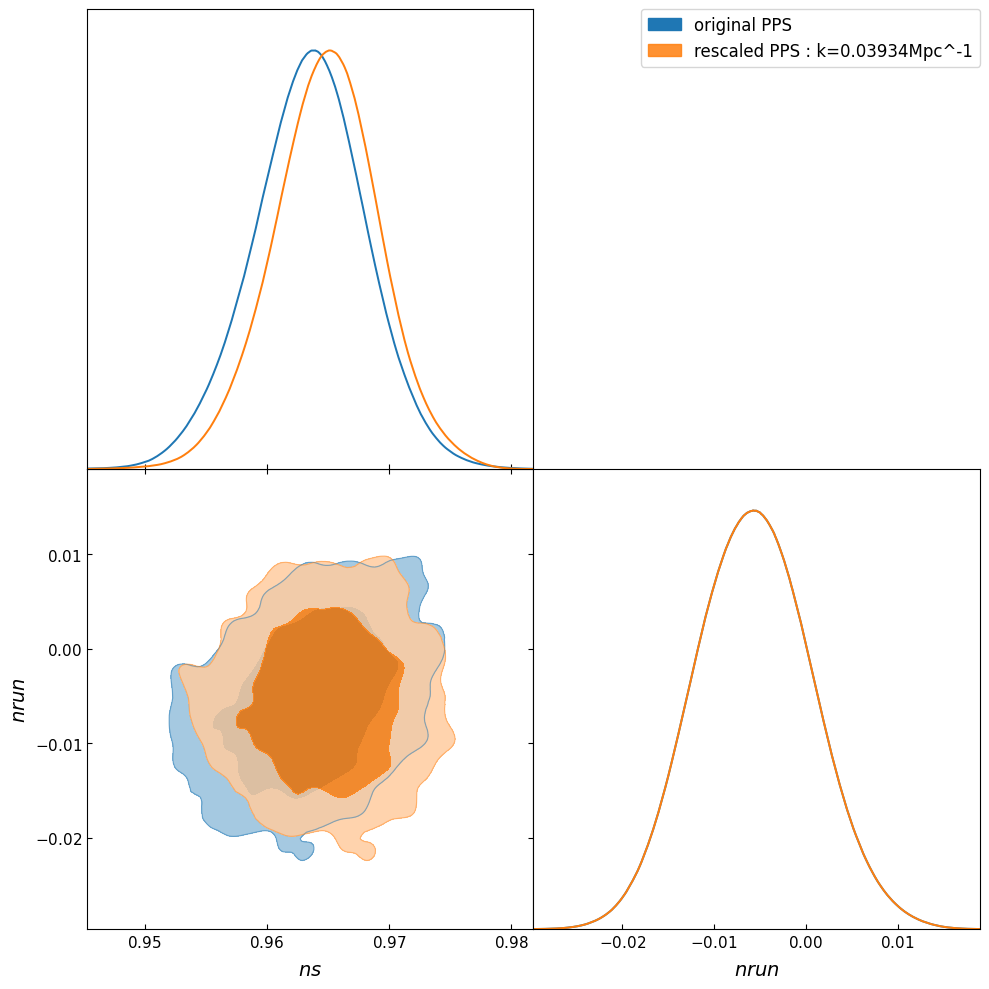

In [8]:
from getdist import plots, MCSamples

sample_orig = MCSamples(
    samples=p.output_only_chains()[:,1:],
    weights=p.weights,
    loglikes = p.likelihood,
    names=p.parmnames[5:7],
    labels=p.parmnames[5:7],
    label='Original PPS',
    settings={'smooth_scale_2D':0.2}
)
sample_resc = MCSamples(
    samples=p2.output_only_chains()[:,1:],
    weights=p2.weights,
    loglikes = p2.likelihood,
    names=p2.parmnames[5:7],
    labels=p2.parmnames[5:7],
    label='Rescaled PPS',
    settings={'smooth_scale_2D':0.2}
)
g0 = plots.get_subplot_plotter(width_inch=10)
g0.triangle_plot([sample_orig, sample_resc], filled=True,
                 legend_labels = ['original PPS', f'rescaled PPS : k={k_uncorr:.5f}Mpc^-1'],
                legend_loc='upper right', contour_colors=['C0', 'C1'], contour_lw=2, contour_ls='solid'
                )

In [9]:
print('k=0.05 : ', sample_orig.getLikeStats())
print(f'k={k_uncorr:0.5f} : ', sample_resc.getLikeStats())

k=0.05 :  Best fit sample -log(Like) = 1387.071000
Ln(mean 1/like) = 1405.258068
mean(-Ln(like)) = 1395.980442
-Ln(mean like)  = 1392.028736
2*Var(Ln(like)) = 25.028480

parameter   bestfit        lower1         upper1         lower2         upper2
ns          9.6427900E-01  9.4849520E-01  9.8076830E-01  9.4453840E-01  9.8123780E-01   ns
nrun       -5.0916790E-03 -2.5373140E-02  1.4952030E-02 -2.5373140E-02  1.4952030E-02   nrun

k=0.03934 :  Best fit sample -log(Like) = 1387.071000
Ln(mean 1/like) = 1405.258068
mean(-Ln(like)) = 1395.980442
-Ln(mean like)  = 1392.028736
2*Var(Ln(like)) = 25.028480

parameter   bestfit        lower1         upper1         lower2         upper2
ns          9.6549963E-01  9.4924937E-01  9.7783492E-01  9.4729309E-01  9.7934000E-01   ns
nrun       -5.0916790E-03 -2.5373140E-02  1.4952030E-02 -2.5373140E-02  1.4952030E-02   nrun



In [10]:
for i in range(4):
    chainfile = f'./plikHM_TTTEEE_lowl_lowE/base_nrun_plikHM_TTTEEE_lowl_lowE_{i+1}.txt'
    parmfile = './plikHM_TTTEEE_lowl_lowE/base_nrun_plikHM_TTTEEE_lowl_lowE.paramnames'
    p = PPSchain(chainfile, parmfile, k_pivot=0.05)
    if i == 0:
        p_merged = p
    else:
        p_merged = p_merged.merge_chain([p])

In [14]:
_, k2_uncorr = p_merged.get_uncorr_k()
p2_merged = p_merged.PPS_run_rescale_chain(k2_uncorr)

success: Uncorrelated k_pivot = 0.04012


Removed no burn in
Removed no burn in


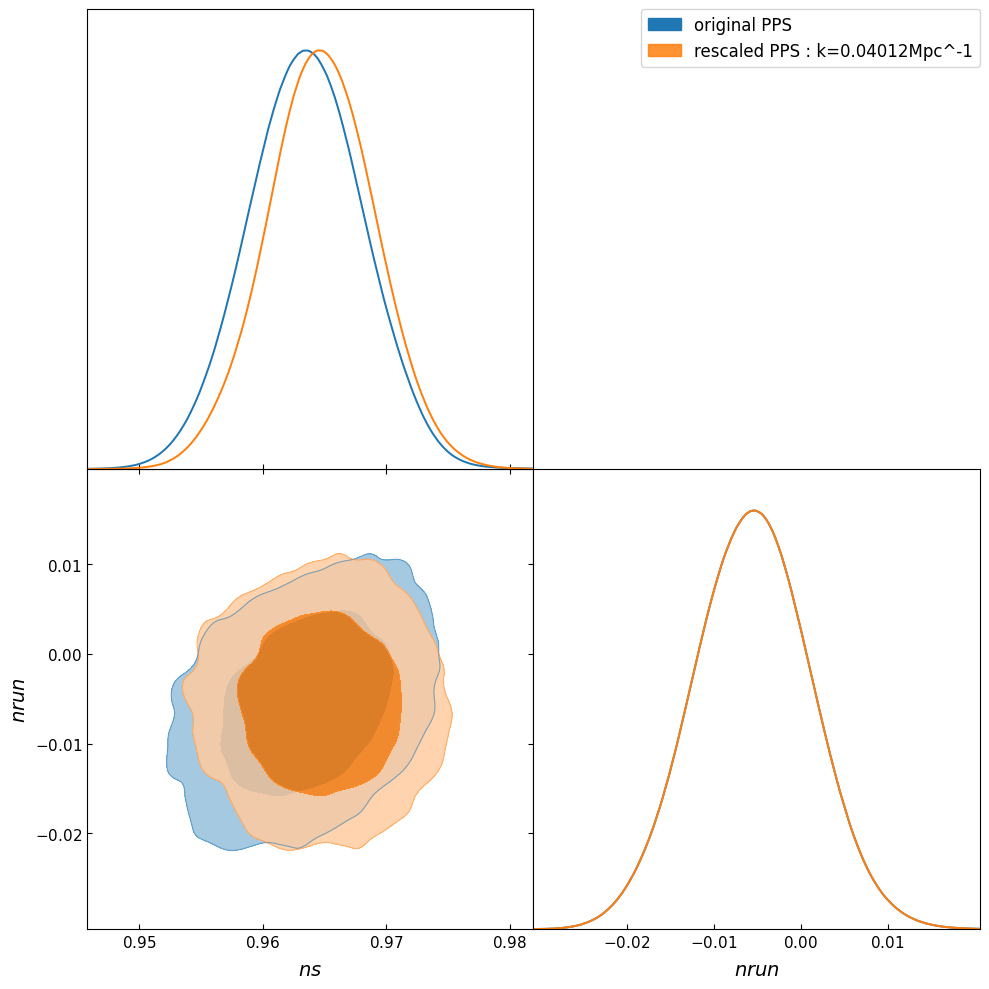

In [15]:
sample_orig = MCSamples(
    samples=p_merged.output_only_chains()[:,1:],
    weights=p_merged.weights,
    loglikes = p_merged.likelihood,
    names=p_merged.parmnames[5:7],
    labels=p_merged.parmnames[5:7],
    label='Original PPS',
    settings={'smooth_scale_2D':0.2}
)
sample_resc = MCSamples(
    samples=p2_merged.output_only_chains()[:,1:],
    weights=p2_merged.weights,
    loglikes = p2_merged.likelihood,
    names=p2_merged.parmnames[5:7],
    labels=p2_merged.parmnames[5:7],
    label='Rescaled PPS',
    settings={'smooth_scale_2D':0.2}
)
g0 = plots.get_subplot_plotter(width_inch=10)
g0.triangle_plot([sample_orig, sample_resc], filled=True,
                 legend_labels = ['original PPS', f'rescaled PPS : k={k2_uncorr:.5f}Mpc^-1'],
                legend_loc='upper right', contour_colors=['C0', 'C1'], contour_lw=2, contour_ls='solid'
                )

In [17]:
print('merged k=0.05 : ', sample_orig.getLikeStats())
print(f'merged k={k2_uncorr:0.5f} : ', sample_resc.getLikeStats())

merged k=0.05 :  Best fit sample -log(Like) = 1386.193000
Ln(mean 1/like) = 1405.025231
mean(-Ln(like)) = 1396.109480
-Ln(mean like)  = 1392.164717
2*Var(Ln(like)) = 25.804511

parameter   bestfit        lower1         upper1         lower2         upper2
ns          9.6722460E-01  9.4816590E-01  9.8136060E-01  9.4453840E-01  9.8410710E-01   ns
nrun       -3.9465370E-03 -2.7225450E-02  1.6964370E-02 -2.8917670E-02  2.0884910E-02   nrun

merged k=0.04012 :  Best fit sample -log(Like) = 1386.193000
Ln(mean 1/like) = 1405.025231
mean(-Ln(like)) = 1396.109480
-Ln(mean like)  = 1392.164717
2*Var(Ln(like)) = 25.804511

parameter   bestfit        lower1         upper1         lower2         upper2
ns          9.6809390E-01  9.4918814E-01  9.8222337E-01  9.4707907E-01  9.8222337E-01   ns
nrun       -3.9465370E-03 -2.7225450E-02  1.6964370E-02 -2.8917670E-02  2.0884910E-02   nrun

